In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ssm

from data_processing import *

np.random.seed(42)

In [2]:
alldat = load_data()

In [15]:
def print_trial_outcome(dat, trial_idx):
    if dat['contrast_left'][trial_idx] != 0 and dat['contrast_right'][trial_idx] != 0:
        stimulus = "Both left: {}%, right: {}%".format(dat['contrast_left'][trial_idx]*100, 100*dat['contrast_right'][trial_idx]) 
    elif dat['contrast_left'][trial_idx] != 0.0:
        stimulus = "Left {}%".format(dat['contrast_left'][trial_idx]*100)
    elif dat['contrast_right'][trial_idx] != 0.0:
        stimulus = "Right {}%".format(dat['contrast_right'][trial_idx]*100)
    else:
        stimulus = "Neither"
    
    response = ["Right", "NoGo", "Left"][int(dat['response'][trial_idx]+1)]
    
    feedback = "Reward" if dat['feedback_type'][trial_idx] == 1 else "White noise"
    
    print("-------- Trial number {} --------".format(trial_idx))
    print("Stimulus:", stimulus)
    print("Response:", response)
    print("Feedback:", feedback)

In [25]:
def train_hmm(spk, brain_area, n_states, start=0, stop=250):
    dat = alldat[session]
    spks = dat['spks'][dat['brain_area'] == brain_area]
    spks = spks[:,:,start:stop]
    data= np.transpose(spks, (1,2,0)) # n_trials x n_timesteps x n_neurons
    
    # train/test split
    train_data, test_data, rdm_idx = data_split(data, int(0.8*len(data)))
    train_data = list(train_data)
    test_data = list(test_data)

    n_neurons = train_data[0].shape[1]
    
    # create the hmm
    hmm = ssm.HMM(n_states, n_neurons, observations="poisson", transitions="standard")
    lls = hmm.fit(list(train_data), method='em')
    
    return hmm, lls, dat, rdm_idx, train_data, test_data


def viz_hmm(res):
    hmm, lls, dat, rdm_idx, train_data, test_data = res
    print("Train ll:", lls[-1])
    test_ll = hmm.log_likelihood(list(test_data))
    print("Test ll:", test_ll)
    plt.plot(lls)
    plt.title("Log likelihood")
    plt.show()
    
    
    learned_transition_mat = hmm.transitions.transition_matrix

    fig = plt.figure(figsize=(8, 4))
    im = plt.imshow(learned_transition_mat)
    plt.title("Learned transition matrix")

    cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    
    fig = plt.figure(figsize=(8, 8))
    for i, log_lambda in enumerate(hmm.observations.log_lambdas):
        plt.subplot(len(hmm.observations.log_lambdas), 1, i+1)
        plt.title("Latent state {}".format(i))
        plt.bar(np.arange(len(log_lambda)), np.exp(log_lambda))
        print(np.argmax(log_lambda))
    plt.tight_layout()
    plt.show()
    
    
    test_trial = 5
    test_trial_spikes = train_data[test_trial]
    print_trial_outcome(dat, rdm_idx[test_trial])
    posterior = hmm.filter(test_trial_spikes)
    
    # plot posterior of states for a single test trial
    plt.figure(figsize=(10, 4))
    plt.title("Posterior distribution of the latent state")
    for i in range(n_states):
        plt.plot(posterior[:,i], label="State %d" % i)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(dat['wheel'][0,rdm_idx[test_trial]])
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.plot(dat['face'][0,rdm_idx[test_trial]])
    plt.show()

In [36]:
session = 11
brain_area = "VISp"
n_states = 5

res1 = train_hmm(session, brain_area, n_states, start=0, stop=250)

HBox(children=(FloatProgress(value=0.0), HTML(value='')))

In [37]:
def plot_vlines(label=False):
    plt.axvline(dat['gocue'][trial_idx,0], color="black", linestyle="--", label="Go cue" if label else "")
    plt.axvline(dat['feedback_time'][trial_idx,0], color="tab:red", linestyle="--", label="Feedback" if label else "")
    plt.axvline(dat['response_time'][trial_idx,0], color="tab:orange", linestyle="--", label="Response" if label else "")
    plt.axvline(0, color="tab:green", linestyle="--", label="Stim onset" if label else "")


def plot_posterior(res):
    hmm, lls, dat, rdm_idx, train_data, test_data = res
    test_trials = [0, 10, 23, 50, 51, 52, 59, 60, 70, 61, 72, 73, 80, 81, 82, 100, 101]

    for test_trial in test_trials:
        test_trial_spikes = train_data[test_trial]
        print_trial_outcome(dat, rdm_idx[test_trial])
        posterior = hmm.filter(test_trial_spikes)

        # plot posterior of states for a single test trial
        plt.figure(figsize=(10, 2))
        plt.title("Posterior distribution of the latent state")
        for i in range(n_states):
            plt.plot(posterior[:,i], label="State %d" % i)
        plt.legend()
        plt.show()

#     plt.figure(figsize=(10, 4))
#     plt.plot(np.cumsum(dat['wheel'][0,rdm_idx[test_trial]]))
#     plt.show()
    
    
#     plt.figure(figsize=(10, 4))
# #     plt.plot(dat['pupil'][0,rdm_idx[test_trial]])
#     plt.plot(dat['pupil'][1,rdm_idx[test_trial]])
#     plt.plot(dat['pupil'][2,rdm_idx[test_trial]])
#     plt.show()
    
#     plt.figure(figsize=(10, 4))
#     plt.plot(dat['face'][0,rdm_idx[test_trial]])
#     plt.show()

# show feedback time,licks,gocue,response_time

* Seems to be a small red/green bump even when there is no stimulus, exactly at the stimulus onset time. Is it a kind of prediction ?
* When n_states = 3, green when only right stimulus ?
* When n_states = 4, red/greend when the visual stimulus is presented, either right or left -> not always...

-------- Trial number 84 --------
Stimulus: Left 25.0%
Response: Left
Feedback: Reward


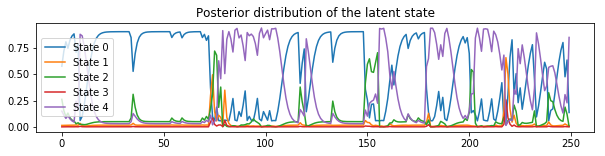

-------- Trial number 123 --------
Stimulus: Both left: 100.0%, right: 50.0%
Response: Left
Feedback: Reward


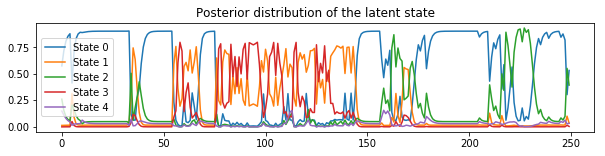

-------- Trial number 39 --------
Stimulus: Both left: 100.0%, right: 50.0%
Response: Left
Feedback: Reward


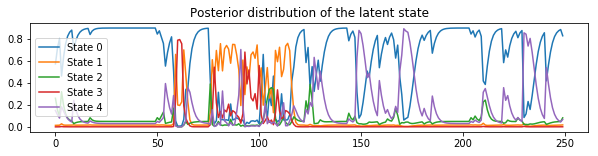

-------- Trial number 314 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


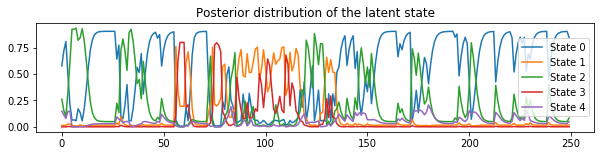

-------- Trial number 285 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


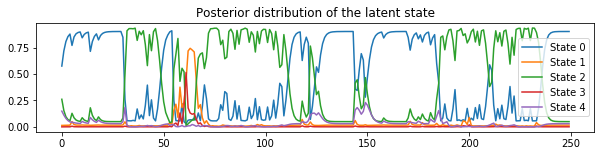

-------- Trial number 59 --------
Stimulus: Both left: 50.0%, right: 25.0%
Response: Right
Feedback: White noise


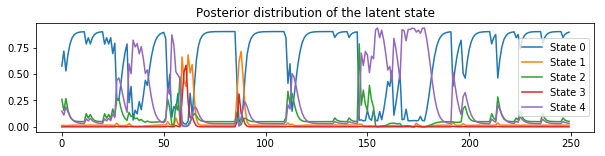

-------- Trial number 305 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


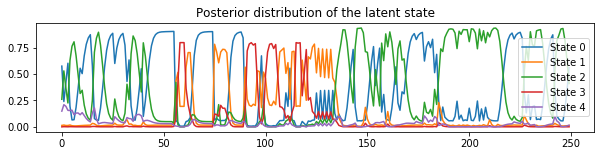

-------- Trial number 142 --------
Stimulus: Both left: 25.0%, right: 50.0%
Response: Right
Feedback: Reward


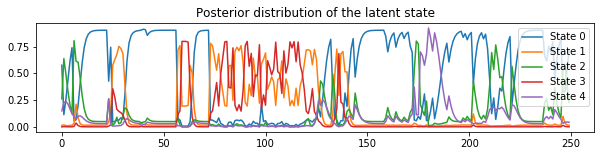

-------- Trial number 157 --------
Stimulus: Both left: 100.0%, right: 100.0%
Response: Left
Feedback: Reward


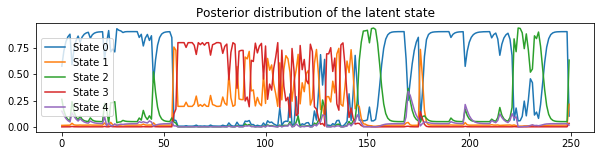

-------- Trial number 248 --------
Stimulus: Right 100.0%
Response: Right
Feedback: Reward


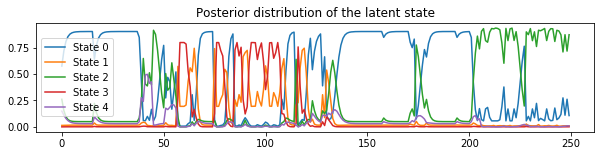

-------- Trial number 249 --------
Stimulus: Both left: 50.0%, right: 50.0%
Response: Left
Feedback: Reward


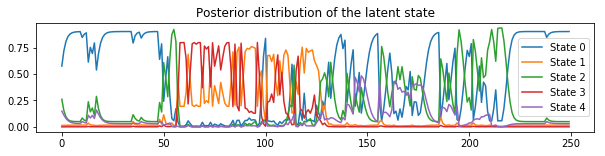

-------- Trial number 32 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


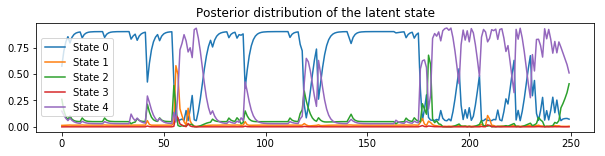

-------- Trial number 319 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


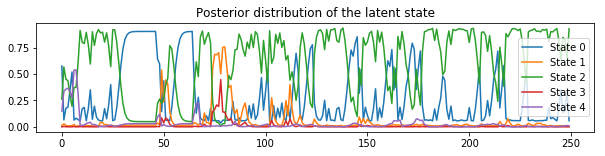

-------- Trial number 69 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


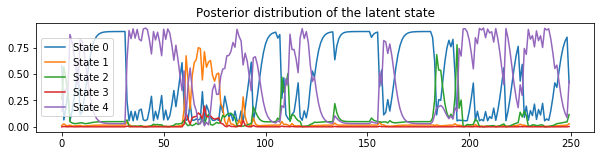

-------- Trial number 5 --------
Stimulus: Both left: 50.0%, right: 50.0%
Response: Right
Feedback: Reward


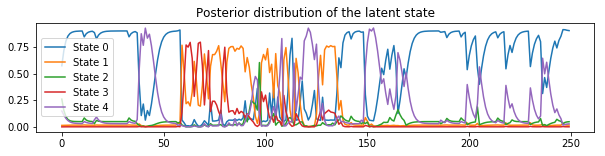

-------- Trial number 47 --------
Stimulus: Both left: 25.0%, right: 100.0%
Response: Right
Feedback: Reward


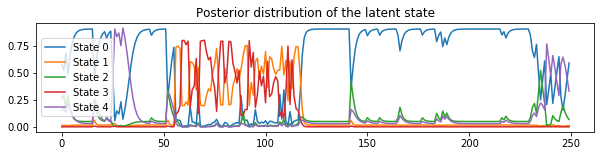

-------- Trial number 229 --------
Stimulus: Both left: 50.0%, right: 100.0%
Response: Left
Feedback: White noise


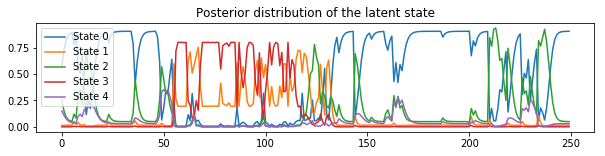

In [38]:
plot_posterior(res1)

## VISp

In [34]:
session = 11
brain_area = "VISp"
n_states = 3

res2 = train_hmm(session, brain_area, n_states, start=0, stop=250)

HBox(children=(FloatProgress(value=0.0), HTML(value='')))

-------- Trial number 166 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


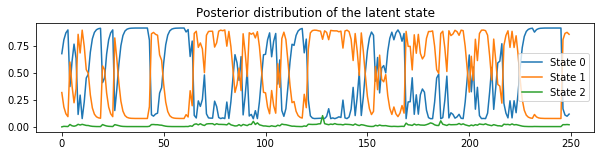

-------- Trial number 70 --------
Stimulus: Both left: 100.0%, right: 25.0%
Response: Left
Feedback: Reward


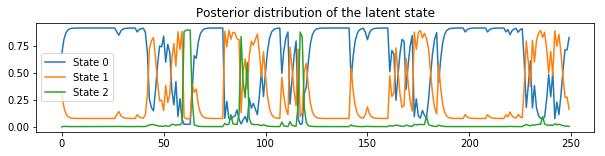

-------- Trial number 3 --------
Stimulus: Both left: 100.0%, right: 50.0%
Response: Left
Feedback: Reward


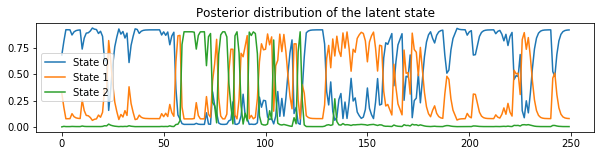

-------- Trial number 116 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


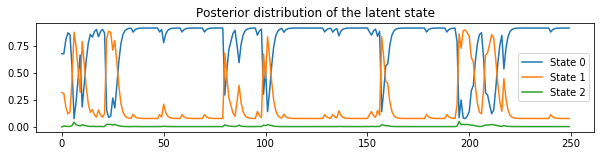

-------- Trial number 140 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


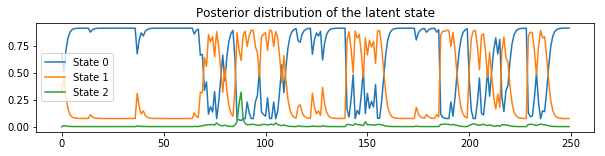

-------- Trial number 56 --------
Stimulus: Left 50.0%
Response: Left
Feedback: Reward


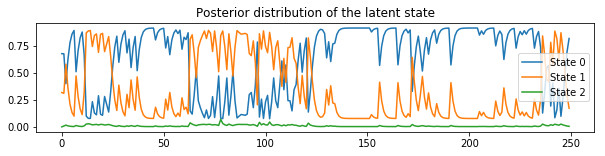

-------- Trial number 7 --------
Stimulus: Right 100.0%
Response: Right
Feedback: Reward


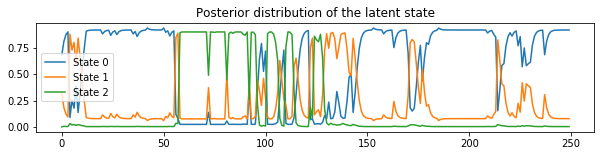

-------- Trial number 15 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


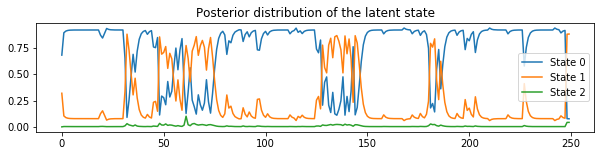

-------- Trial number 316 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


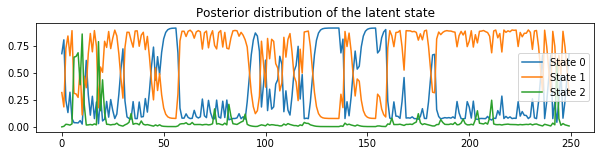

-------- Trial number 308 --------
Stimulus: Both left: 100.0%, right: 100.0%
Response: Left
Feedback: Reward


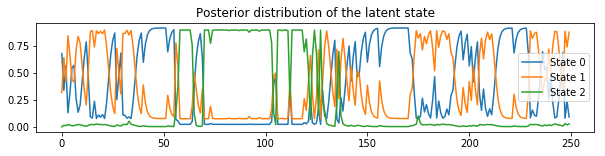

-------- Trial number 21 --------
Stimulus: Left 25.0%
Response: Right
Feedback: White noise


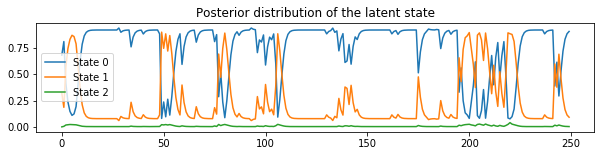

-------- Trial number 215 --------
Stimulus: Both left: 25.0%, right: 100.0%
Response: Right
Feedback: Reward


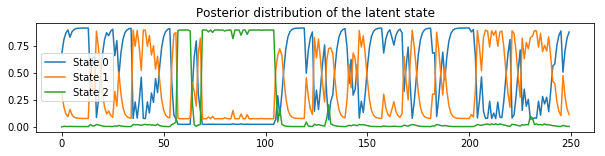

-------- Trial number 182 --------
Stimulus: Neither
Response: Right
Feedback: White noise


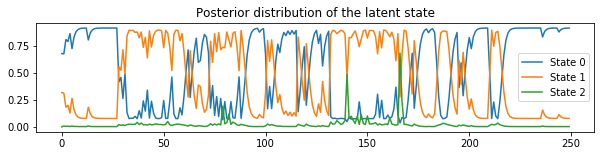

-------- Trial number 229 --------
Stimulus: Both left: 50.0%, right: 100.0%
Response: Left
Feedback: White noise


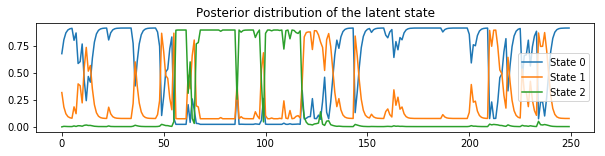

-------- Trial number 145 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


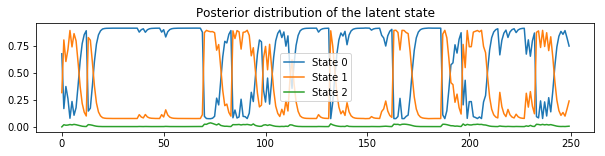

-------- Trial number 259 --------
Stimulus: Left 50.0%
Response: Left
Feedback: Reward


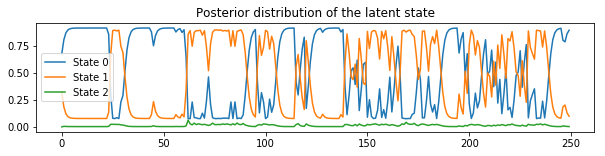

-------- Trial number 327 --------
Stimulus: Right 100.0%
Response: NoGo
Feedback: White noise


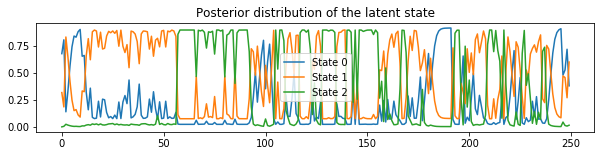

In [35]:
plot_posterior(res2)


## VISam

In [39]:
session = 11
brain_area = "VISam"
n_states = 3

res3 = train_hmm(session, brain_area, n_states, start=0, stop=250)

HBox(children=(FloatProgress(value=0.0), HTML(value='')))

* Most of the times, orange when the stimulus is presented. But there are some exceptions: no stimulus but still orange latent state -> is it a prediction of a stimulus by the mouse ?

-------- Trial number 296 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


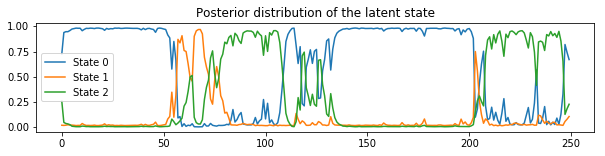

-------- Trial number 334 --------
Stimulus: Right 100.0%
Response: NoGo
Feedback: White noise


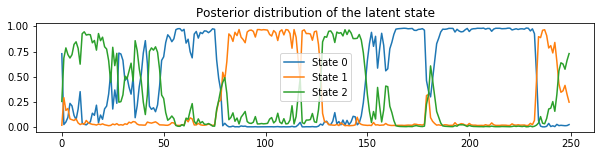

-------- Trial number 248 --------
Stimulus: Right 100.0%
Response: Right
Feedback: Reward


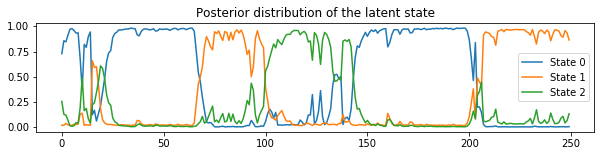

-------- Trial number 142 --------
Stimulus: Both left: 25.0%, right: 50.0%
Response: Right
Feedback: Reward


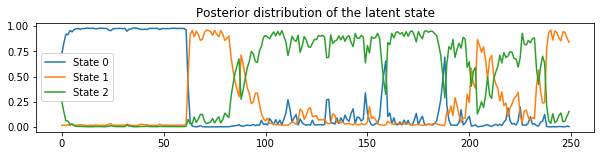

-------- Trial number 255 --------
Stimulus: Left 50.0%
Response: Left
Feedback: Reward


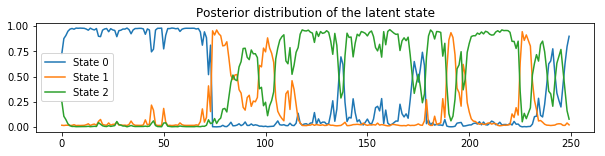

-------- Trial number 158 --------
Stimulus: Both left: 50.0%, right: 25.0%
Response: Left
Feedback: Reward


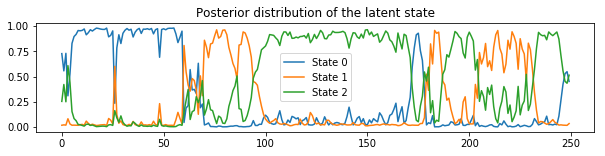

-------- Trial number 229 --------
Stimulus: Both left: 50.0%, right: 100.0%
Response: Left
Feedback: White noise


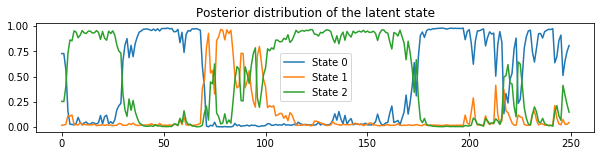

-------- Trial number 242 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


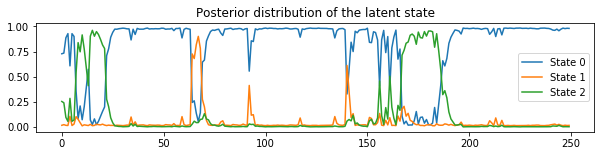

-------- Trial number 323 --------
Stimulus: Both left: 25.0%, right: 25.0%
Response: Left
Feedback: Reward


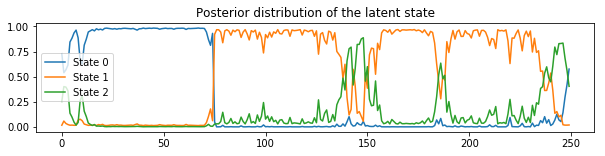

-------- Trial number 74 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


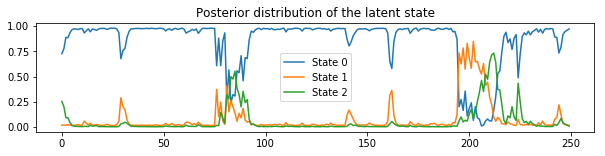

-------- Trial number 213 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


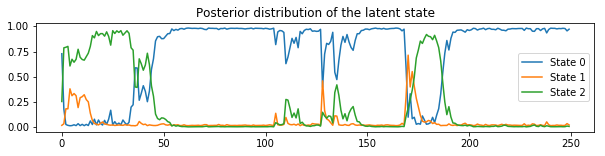

-------- Trial number 315 --------
Stimulus: Left 25.0%
Response: NoGo
Feedback: White noise


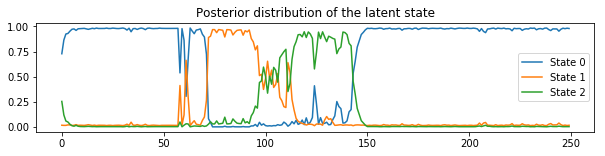

-------- Trial number 85 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


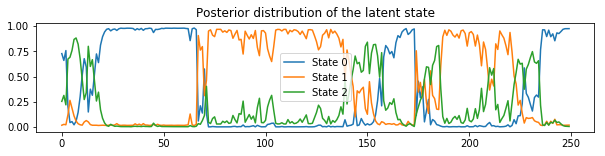

-------- Trial number 52 --------
Stimulus: Both left: 100.0%, right: 100.0%
Response: Right
Feedback: Reward


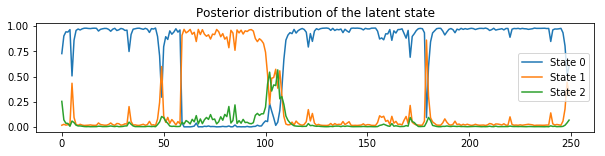

-------- Trial number 331 --------
Stimulus: Right 100.0%
Response: NoGo
Feedback: White noise


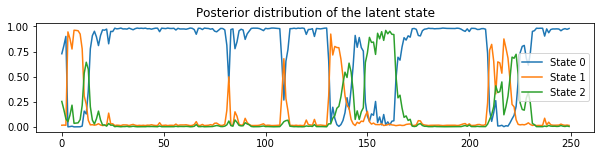

-------- Trial number 121 --------
Stimulus: Neither
Response: Right
Feedback: White noise


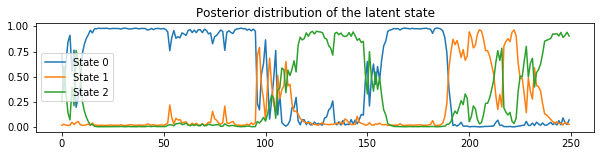

-------- Trial number 201 --------
Stimulus: Neither
Response: Right
Feedback: White noise


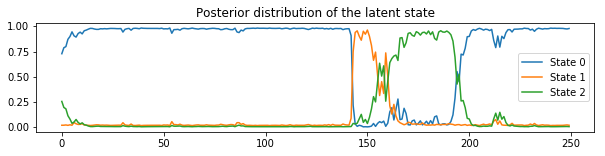

In [40]:
plot_posterior(res3)